<img src="img/dsci572_header.png" width="600">

# Lecture 3: Stochastic Gradient Descent and Introduction to Neural Networks 



<br><br><br>

## Lecture Learning Objectives


- Explain and implement the stochastic gradient descent algorithm

- Explain the advantages and disadvantages of stochastic gradient descent as compared to gradient descent
- Explain what are epochs, batch sizes, iterations, and computations in the context of gradient descent and stochastic gradient descent

- Explain fundamental concepts of neural networks such as layers, nodes, connections, activation functions etc.
- Carry out forward pass in feedforward neural networks. 

<br><br><br>

## Imports


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.plotting import *

<br><br><br>

## ❓❓ Questions for you

### Exercise 3.1

**iClicker cloud join link: https://join.iclicker.com/SDMQ**

**Select all of the following statements which are TRUE.**

- (A) Gradient Descent is a technique used primarily for regression tasks.
- (B) Gradient Descent is guaranteed to find the global minimum for any type of loss function.
- (C) Using a very high learning rate in Gradient Descent may result in overshooting the minimum, potentially leading to an increase in the loss value with each iteration.
- (D) In Gradient Descent, using scaled features often helps in achieving faster convergence by ensuring features contribute more equally to the loss function.
- (E) For a data matrix of dimensions $10^6 \times 10^3$, in the context of a simple linear model, gradient descent will perform $\approx 10^9$ computations per iteration, at a minimum.

<br><br><br><br>

```{admonition} V's Solutions!
:class: tip, dropdown
C, D, E
```

## Notation recap

$$
\mathbf{Y}=
\left[
\begin{array}{c} y_1 \\
\vdots \\
y_i \\
\vdots\\
y_n
\end{array}
\right], \quad
\mathbf{X}=
\left[
\begin{array}{c} \mathbf{x}_1 \\
\vdots \\
\mathbf{x}_i \\
\vdots\\
\mathbf{x}_n
\end{array}
\right]
\left[\begin{array}{cccc}
x_{11} & x_{12} & \cdots & x_{1 d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{i 1} & x_{i 2} & \cdots & x_{i d}\\
\vdots & \vdots & \ddots & \vdots \\
x_{n 1} & x_{n 2} & \cdots & x_{n d}
\end{array}\right],
\quad
\mathbf{w}=
\left[
\begin{array}{ccc}
w_1 &  \cdots & w_d
\end{array}
\right]
$$

- $n$: number of samples
- $d$: number of input features/dimensions

<br><br><br>

## Motivation for Stochastic Gradient Descent


- Last lecture we looked at "vanilla" gradient descent

- Almost all loss functions you'll use in ML involve a sum over all the (training) data, e.g., mean squared error

- For example, we have the following loss function for a linear regression model:

In vector format:

$$\text{MSE} = \mathcal{L}(\mathbf{w}) = \frac{1}{n}\sum^{n}_{i=1}(\mathbf{x}_i \mathbf{w} - y_i)^2$$

In full-matrix format

$$\text{MSE} = \mathcal{L}(\mathbf{w}) = \frac{1}{n}(\mathbf{X} \mathbf{w} - \mathbf{y})^T (\mathbf{X} \mathbf{w} - \mathbf{y}) $$

- The goal is to find the weights $\mathbf{w}$ that minimize the loss function

- With gradient descent we:

    1. start with some arbitrary $\mathbf{w}$

    2. calculate the gradient using all training examples
    3. use the gradient to adjust $\mathbf{w}$
    4. repeat for $I$ iterations or until the step-size is sufficiently small

<br><br><br>

- But if we have large $n$ and/or $\mathbf{w}$, gradient descent becomes very computationally expensive (when we get to deep learning, we'll have models where the number of weights to optimize is in the millions)

- Say `n = 1,000,000`, we have 1000 parameters to optimize, and we do 1000 iterations = $O(10^{12})$ computations
  
    - For each data point, we need to compute gradients with respect to each of model parameter.
      
    - For each iteration, it'll have to compute $10^6 \times 10^3 = 10^9$ gradients
 

- We can reduce this workload by using just a fraction of our dataset to update our parameters each iteration (rather than using the whole data set)

- This is called **stochastic gradient descent** [1]

[1]: "Stochastic" and "random" mean the same thing for our purposes. There is, however, a subtle difference as described [here](https://en.wikipedia.org/wiki/Stochastic): "_Although stochasticity and randomness are distinct in that the former refers to a modeling approach and the latter refers to phenomena themselves, these two terms are often used synonymously._"

<br><br><br>

## Stochastic Gradient Descent


**Gradient Descent**

Loss function:

$$\text{MSE} = \mathcal{L}(\mathbf{w}) = \frac{1}{n}\sum^{n}_{i=1} (\mathbf{x}_i \mathbf{w} - y_i)^2$$

Update procedure:

$$\mathbf{w}^{j+1} = \mathbf{w}^{j} - \alpha \nabla_\mathbf{w} \mathcal{L}(\mathbf{w}^{j})$$

<br><br><br>

**Stochastic Gradient Descent**

Loss function:

$$\text{MSE}_i = \mathcal{L}_i(\mathbf{w}) = (\mathbf{x}_i \mathbf{w} - y_i)^2$$

Update procedure:
$$\mathbf{w}^{j+1} = \mathbf{w}^{j} - \alpha \nabla_\mathbf{w} \mathcal{L}_i(\mathbf{w}^{j})$$

<br><br><br>

- In stochastic gradient descent, instead of updating our parameters based on a gradient calculated using all training data, we simply use **one of our data points** (the $i$-th one)

- This is best seen by example, let's use the Pokemon dataset from last week:

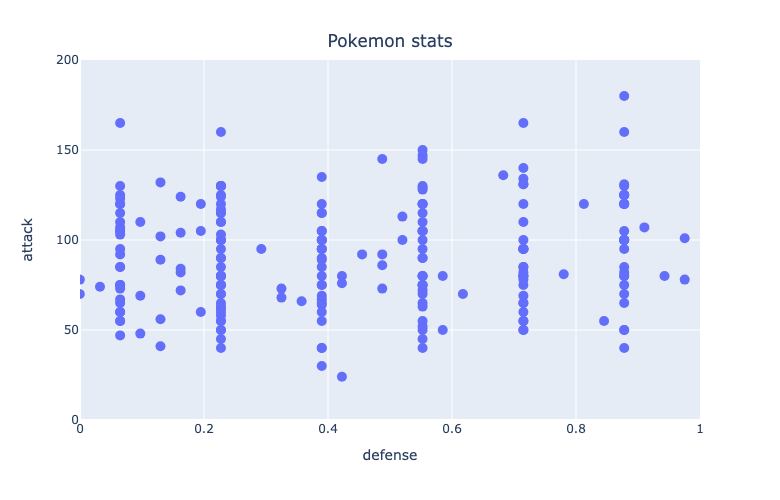

In [2]:
df = (pd.read_csv("data/pokemon.csv", usecols=['name', 'defense', 'attack'], index_col=0)
        .reset_index()
     )
x = StandardScaler().fit_transform(df[['defense']]).flatten()
y = df['attack'].to_numpy()
plot_pokemon(x, y, x_range=[0, 1], y_range=[0, 200], dx=0.2, dy=50)

<br><br><br>

- Let's fit a linear model to this data

- Recall from last lecture that the gradient of the MSE loss function for a linear regression model is:

$$\nabla_\mathbf{w} \mathcal{L}(\mathbf{w})  = \frac{2}{n} \mathbf{X}^T (\mathbf{X} \mathbf{w}^T - \mathbf{y})$$

In [3]:
def gradient(w, X, y):
    """Gradient of mean squared error."""
    n = len(X)
    return (2/n) * X.T @ (X @ w.T - y)

<br><br><br>

- Let's use the column-of-ones trick to add a column of ones to our feature data to represent the intercept term:

In [4]:
X = np.hstack((np.ones((len(x), 1)), x[:, None]))
X

array([[ 1.        , -0.78077335],
       [ 1.        , -0.32548801],
       [ 1.        ,  1.62573488],
       ...,
       [ 1.        , -0.65069183],
       [ 1.        ,  0.91028648],
       [ 1.        ,  1.36557183]])

In [5]:
X.shape

(801, 2)

<br><br><br>

- Let's calculate the gradient for parameters `(w0, w1)` = `(-20, -5)` using the full data set:

In [6]:
w = np.array([-20., -5])
gradient(w, X, y) # Gradient on the entire dataset

array([-195.71535581,  -40.14066881])

<br><br><br>

- And now let's calculate the gradient again using just a **single random point** (re-run this as many times as you like):

In [7]:
i = np.random.randint(0, len(X), 1)

print("Selected point:")
display(df.iloc[i])

print("      Gradient: [intercept, slope]")
print(f"      All data: {[round(_, 2) for _ in gradient(w, X, y)]}")
print(f"Data point {i[0]:03}: {[round(_, 2) for _ in gradient(w, X[i], y[i])]}")

Selected point:


name  attack  defense
143  Articuno      85      100

      Gradient: [intercept, slope]
      All data: [-195.72, -40.14]
Data point 143: [-218.78, -192.04]


<br><br><br>

- Not surprisingly, the gradient calculated using just one data point is (usually) different to the gradient calculated using all data points

- For visualization purposes, let's assume the intercept is fixed and just look at the gradient with respect to the slope parameter ($w_1$) at $w_1=-5$ at different data points:

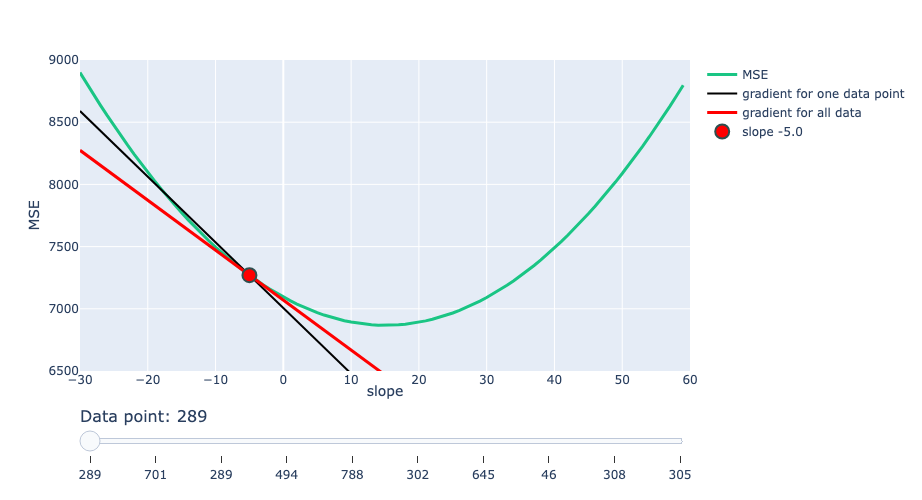

In [8]:
plot_random_gradients(x, y, w=w[1], seed=1132)  # re-run to get different datapoints

- Notice here that at a slope of -5, our single-point gradients vary in direction and magnitude

- Let's plot a histogram of the gradient of each data point at a slope of -5:

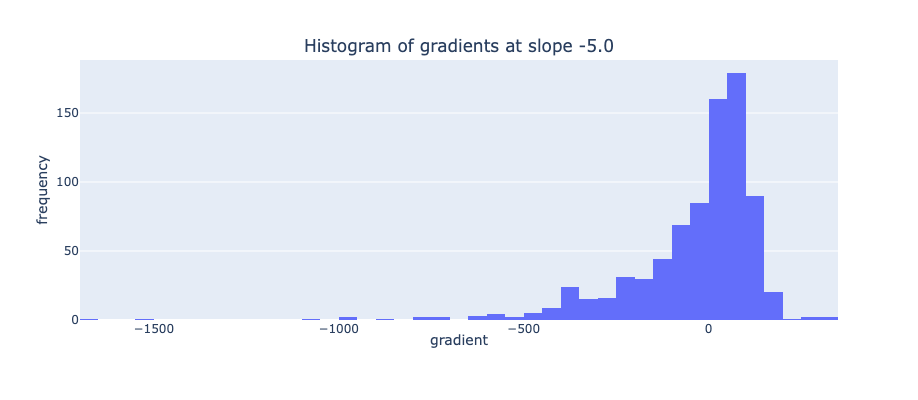

In [9]:
plot_gradient_histogram(x, y, w=w[1])

- The histogram is left-skewed, indicating that more often than not, our gradient is negative. This means that we need to increase $w$ to decrease our loss. if you look at the plot above this one, you'll see that makes sense.

- Consequently, we're **more likely to move towards the minimum even if we only use a single data point**
- It seems that using just one data point is computationally way faster, and mathematically not a totally horrible idea

<br><br><br>

- Let's see stochastic gradient descent in action in the 2D case:

    - It's pretty much the same as we saw last lecture, except that we pick a random data point (hence the name "stochastic") using which to calculate the gradient (instead of all data points in vanilla gradient descent)
    
    - I've also removed the "tolerance" termination criteria for simplicity

In [10]:
def stochastic_gradient_descent(x, y, w, alpha, num_iterations=300, print_progress=100, seed=None):
    """Stochastic gradient descent for simple linear regression."""
    
    w = w.copy()  # avoid modifying given w

    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    
    iterations = 1        # init iterations
    if seed is not None:  # init seed (if given)
        np.random.seed(seed)
    
    while iterations <= num_iterations:
        i = np.random.randint(len(x))            # <--- this is different from GD <---
        g = gradient(w, x[i, None], y[i, None])  # <--- this is different from GD <---
        w -= alpha * g                           # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:     # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1  # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

<br><br><br>

In [11]:
alpha = 0.01

w = np.array([-20., -5])
X = np.hstack((np.ones((len(x), 1)), x[:, None]))

stochastic_gradient_descent(X, y, w, alpha, seed=1132)

Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 63.27. Slope 8.83.
Iteration 200. Intercept 71.16. Slope 9.67.
Iteration 300. Intercept 76.68. Slope 14.49.
Terminated!
Iteration 300. Intercept 76.68. Slope 14.49.


<br><br><br>

Let's compare these with `sklearn`'s coefficients: 

In [12]:
m = LinearRegression().fit(np.atleast_2d(x).T, y)
print(f"sklearn Intercept = {m.intercept_:.2f}")
print(f"sklearn Slope = {m.coef_[0]:.2f}")

sklearn Intercept = 77.86
sklearn Slope = 15.07


<br><br><br>

- We got pretty close. Let's see the path we took:

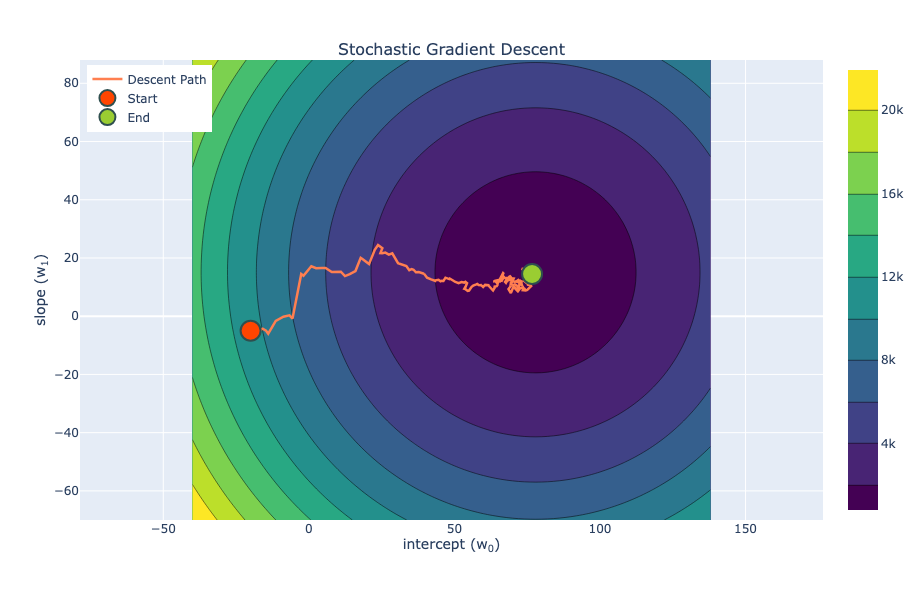

In [13]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-70, 90, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, seed=1132)

- Above, we get to the minimum fairly quickly and then bounce around

- But notice how we bounce around a bit. We get this "noise" because we are only basing our adjustment on one data point.

  - Remember, each data point has it's own idea of what the parameters should be. But it turns out that most of them move us in the right direction (it's just a bit noisy)

 
- In general, SGD is based on the principle that gradient calculated from one data point is, on average, a good approximation of the gradient calculated from the entire dataset.
  
- While the path taken by SGD in the parameter space can be noisy due to this approximation, the overall trajectory tends towards the minimum of the loss function.


Note that if we were to traverse the **overall loss landscape** (the contour plot above), we should have smoothly progressed towards the minimum because the direction of the steepest descent does not change in the above case. However, **the SGD method actually traverses a different loss landscape at each iteration**, which is why the path towards the minimum looks noisy.

<br><br><br>

- Let's compare the result to regular gradient descent:

In [14]:
def gradient_descent(x, y, w, alpha, ϵ=2e-4, max_iterations=5000, print_progress=100):
    """Gradient descent for optimizing simple linear regression."""
    
    w = w.copy()
    
    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1  # init iterations
    dw=np.full_like(w, np.inf)
    
    while np.linalg.norm(dw) > ϵ and iterations <= max_iterations:
        g = gradient(w, x, y)  # calculate current gradient
        dw = alpha * g         # change in w
        w -= dw                # adjust w based on gradient * learning rate
        if iterations % print_progress == 0:  # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1        # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

In [15]:
w

array([-20.,  -5.])

In [16]:
gradient_descent(X, y, w, alpha, max_iterations=300)

Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 64.88. Slope 12.41.
Iteration 200. Intercept 76.14. Slope 14.72.
Iteration 300. Intercept 77.63. Slope 15.02.
Terminated!
Iteration 300. Intercept 77.63. Slope 15.02.


- This got us closer answer as sklearn, let's take a look at the path:

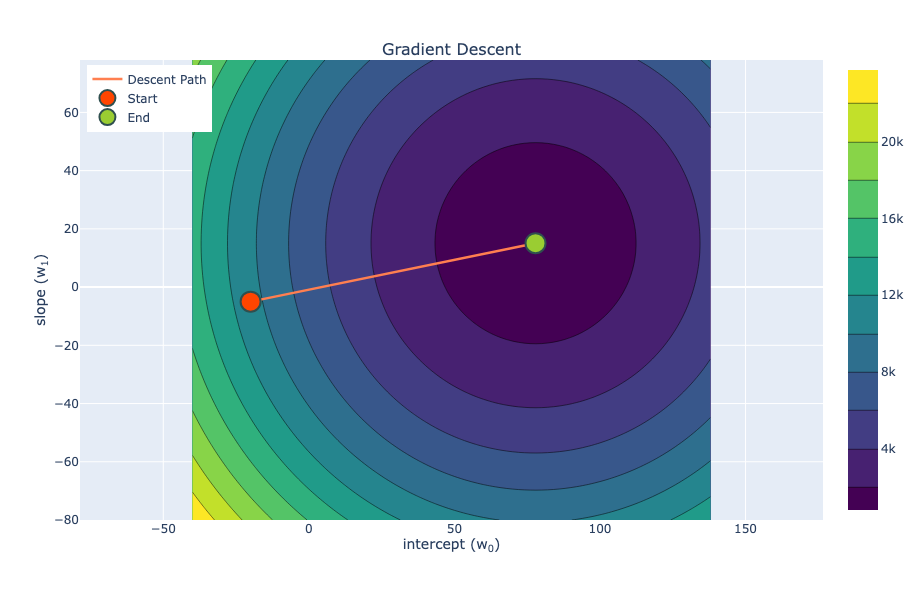

In [17]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-80, 80, 2), np.arange(-40, 140, 2))

Obviously vanilla GD looks nice above, as it consistently moves in the direction of the gradient of the average loss over all examples. 

But consider the computational savings:

- In SGD, we did 300 iterations: 1 iteration = 1 data point, **so we did 300 computations** (didn't use the entire dataset)

- In GD, we converged after 300 iterations: 1 iteration = 801 data points, **so we did 300 x 801 = 240,300 computations**

<br><br><br>

## Mini-batch Gradient Descent

- Okay so it appears SGD is computationally better than GD, but GD looks to be more accurate

- Is there an in-between compromise? Yes!
- Enter: **minibatch** stochastic gradient descent
- The idea here is simple: rather than calculating the gradient from just one random data point, calculate it based on a **batch of data points**:

<br><br><br>

- We would still expect the gradient calculated from a batch to be different to the gradient calculated using all the data, but not as different to using only a single point

In [18]:
batch_size = 5
batch = np.random.choice(range(len(X)), batch_size)
print("Selected points:")
display(df.iloc[batch])
print("   Gradient of: [intercept, slope]")
print(f"      All data: {[round(_, 2) for _ in gradient(w, X, y)]}")
print(f"      Data point {batch[0]}: {gradient(w, X[batch[0], None], y[batch[0]])}")
print(f"      Batch {batch}: {gradient(w, X[batch], y[batch])}")

Selected points:


name  attack  defense
752  Fomantis      55       35
706    Klefki      80       91
350  Castform      70       70
515  Simipour      98       63
304    Lairon      90      140

   Gradient of: [intercept, slope]
      All data: [-195.72, -40.14]
      Data point 752: [-137.63941304  170.13039343]
      Batch [752 706 350 515 304]: [-199.40854396  -76.75745086]


- Once again let's visualize this for just the slope parameter to drive the point home:

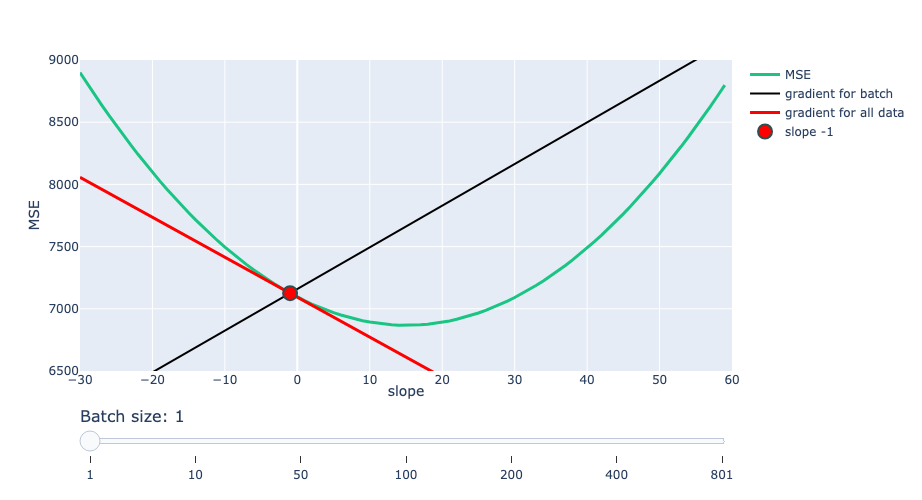

In [19]:
plot_minibatch_gradients(x, y, w=-1, batch_sizes=[1, 10, 50, 100, 200, 400, len(x)], seed=1132)

- The larger the batch, the closer we are to the gradient calculated using the whole dataset

- But also the bigger the batch, the more computations will be needed

<br><br><br>

### Mini-batch creation approaches

When doing SGD, we have 3 approaches:

**Approach 1:** Shuffle the dataset and pre-divide it into batches, like cross-validation. This is "without replacement", every example is used once.

**Approach 2:** Pick a batch of certain size randomly from the dataset **without** replacement. In this case, you won't have the same example occurring more that once in a batch, but you might have the same example in both batch 1 and batch 2. Every example may not be used in this approach.

**Approach 3:** Similar to Approach 2, pick a batch of certain size randomly from the dataset **with** replacement. In this case, even each batch is collected with replacement, so you might have the same example twice in batch 1. Every example may not be used in this approach.

We typically use approach 1 or 2 (the default in PyTorch is approach 1). Empirically, sampling without replacement tends to lead to more optimal solutions/faster convergence and this has been [proved mathematically in some cases](https://arxiv.org/pdf/1202.4184v1.pdf)

<br><br><br>

### Implementation

- We'll be using **Approach 2** from above; i.e., **sampling without replacement** in each iteration

- The code is almost the same as before but we are choosing `batch_size` random points now

For example, I can pick out 10 random indexes without replacement using the following code:

In [20]:
np.random.choice(range(len(X)), size=10, replace=False)

array([574, 484,  79, 399, 366, 415, 378, 639,  53, 226])

<br><br><br>

That's all we need to code the minibatch SGD:

In [21]:
def minibatch_gradient_descent(x, y, w, alpha, batch_size, num_iterations=300, print_progress=100, seed=None):
    """Minibatch gradient descent for simple linear regression."""
    
    w = w.copy()

    print(f"Iteration 0. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
    iterations = 1        # init iterations
    if seed is not None:  # init seed (if given)
        np.random.seed(seed)
        
    while iterations <= num_iterations:
        i = np.random.choice(range(len(x)), batch_size, replace=False)  # <--- this is the new bit <---
        g = gradient(w, x[i], y[i])              # calculate current gradient
        w -= alpha * g                           # adjust w based on gradient * learning rate
        
        if iterations % print_progress == 0:     # periodically print progress
            print(f"Iteration {iterations}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")
        iterations += 1  # increase iteration
        
    print("Terminated!")
    print(f"Iteration {iterations - 1}. Intercept {w[0]:.2f}. Slope {w[1]:.2f}.")

In [22]:
batch_size = 10
minibatch_gradient_descent(X, y, w, alpha, batch_size=batch_size, seed=1132)

Iteration 0. Intercept -20.00. Slope -5.00.
Iteration 100. Intercept 64.46. Slope 12.60.
Iteration 200. Intercept 76.52. Slope 14.85.
Iteration 300. Intercept 77.29. Slope 13.59.
Terminated!
Iteration 300. Intercept 77.29. Slope 13.59.


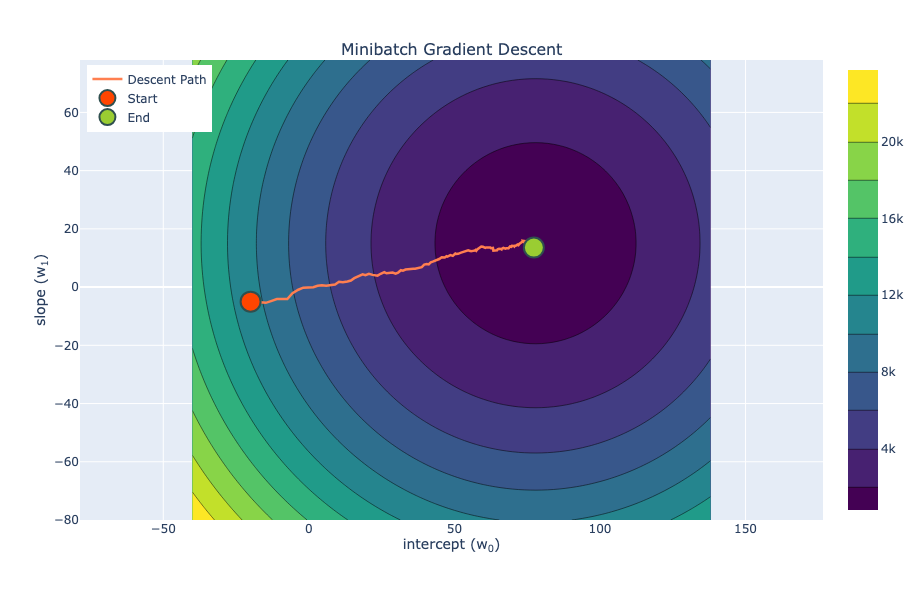

In [23]:
plot_gradient_descent_2d(x, y, w, alpha, np.arange(-80, 80, 2), np.arange(-40, 140, 2), max_iterations=300, stochastic=True, batch_size=batch_size, seed=1132)

- Above, we still get the wobbliness of SGD but it's much smoother now

- Let's see all the results in one figure:

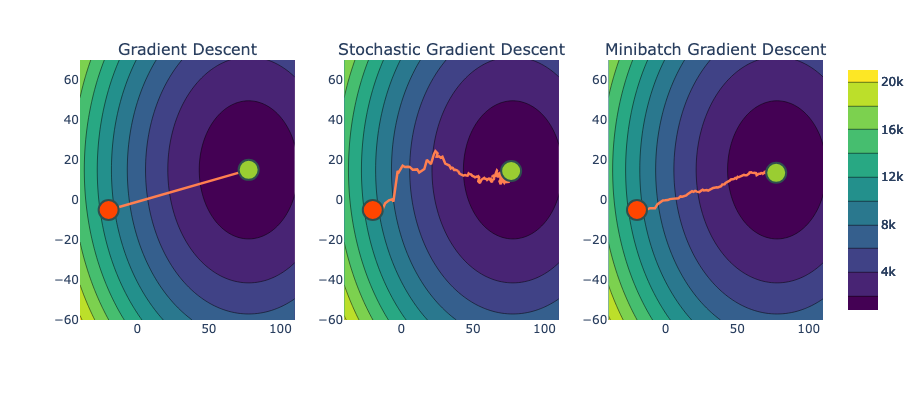

In [24]:
f1 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-60, 80, 2), np.arange(-40, 120, 2))
f2 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-60, 80, 2), np.arange(-40, 120, 2), max_iterations=300, stochastic=True, seed=1132)
f3 = plot_gradient_descent_2d(x, y, w, alpha, np.arange(-60, 80, 2), np.arange(-40, 120, 2), max_iterations=300, stochastic=True, batch_size=batch_size, seed=1132)
plot_panel(f1, f2, f3)

|Method|Intercept|Slope|Iterations|Data Per Iteration|Number of computations|
|---|---|---|---|---|---|
|sklearn|77.86|15.07|-|-|-|
|GD|77.63|15.02|300|801|240,300|
|SGD|76.68|14.49|300|1|300|
|MGD|77.29|13.59|300|10|3000|

<br><br><br>

## Terminology


Assume we have a dataset of $n$ observations (also known as _rows, samples, examples, data points, or points_)

There are three terms you need to know when it comes to gradient descent:

- **Iteration**: each time you update model weights

- **Batch**: a subset of data used in an iteration

- **Epoch**: One full pass through the dataset to look at all $n$ examples

<br><br><br>

Let's put those definitions in context:
- In **GD**, each iteration involves computing the gradient over all examples, so

$$1 \: \text{iteration} = 1 \: \text{epoch}$$

- In **SGD**, each iteration involves one data point, so

$$n \text{ iterations} = 1 \: \text{epoch}$$

- In **MGD**, each iteration involves a batch of data, so

$$
\begin{align}
\frac{n}{\text{batch size}} \text{iterations} &= 1 \text{ epoch}\\
\end{align}
$$

<br><br><br>

From our examples above (recall that $n=801$):

|Method|Iterations|Data Per Iteration (batch size)|Epochs|
|---|---|---|---|
|GD|466|801| 466|
|SGD|300|1|0.37|
|MGD|300|10|3.74|

<br><br><br>

- In practice nobody really says "minibatch SGD", we just say SGD: in SGD you can specify a batch size of anything between 1 and $n$

Note that:
- "_I did 10 iterations of GD_" has a meaning (that's 10 full passes through the dataset).

- "_I did 10 iterations of SGD_" means nothing (it depends what the batch size is).

- "_I did 10 epochs of SGD_" has more meaning (that's 10 full passes through the dataset).

<br><br><br>

## Remarks on SGD


### Learning Rate

- Up until now we've been using a constant learning rate ($\alpha$) in our algorithms
- There are two main ways we could potentially improve on this naive method:

    1. Use an "adaptive" learning rate - where we take big steps when we seem to be far from the minimum of our loss function, and smaller steps when we are close to it;

    2. Use "momentum" - using how our weights have changed in past iterations to influence how it changes in future iterations

- In practice we use fancier variants of GD, such as [Adam](https://arxiv.org/abs/1412.6980), which include more bells and whistles such as those I describe above. We'll be using Adam a lot through the rest of this course.

- These algorithms get pretty complex and it's beyond the scope of the course to know exactly how to derive them, but just know they are essentially fancier versions of GD (coding up Adam will be an optional question in the lab this week and if you're interested in reading more about these kinds of algorithms, see e.g. [here](https://ruder.io/optimizing-gradient-descent/))

<br><br><br>

### Local Minima

In Lab 1, we looked at how optimization algorithms like gradient descent are susceptible to getting stuck in local minima. SGD can help with this due to the randomness in the search.

**Again, note that in SGD the weights are updated in a different loss landscape, and not the overall landscape.** This means that even if we are in a local minimum of the overall loss landscape, we may not be in a local minimum of the batch-loss-landscape, which helps to avoid zero gradients.

The above mentioned algorithms like Adam that include features like momentum and adaptive learning rates are better designed to speed up convergence and try to avoid local minima.

Here's a comparison of SGD vs Adam from the solution for the optional question in Lab 2. Notice how SGD gets stuck in a local minima, while Adam is able to navigate all the way to the global minima:

![](img/adam.png)

## ❓❓ Questions for you

### Exercise 3.2

**iClicker cloud join link: https://join.iclicker.com/SDMQ**

**Select all of the following statements which are TRUE.**

- (A) In SGD, the gradient is calculated using the entire training set in each iteration.
- (B) An epoch in mini-batch GD consists of as many iterations as there are batches in the dataset.
- (C) The number of epochs is the same as the number of iterations in mini-batch GD when the batch size equals the size of the dataset.
- (D) In SGD, increasing the number of epochs will always decrease the loss function value.

```{admonition} V's Solutions!
:class: tip, dropdown
B, C
```

<br><br><br><br>

## Neural Network Basics

So far, we have only talked about linear models: linear regression and logistic regression. But there are functions which cannot be represented by linear models. For example, linear regression cannot represent quadratic or cubic functions or logistic regression cannot represent XOR. 
    
In DSCI 573, we tackled this problem by creating polynomial features, or basis functions. E.g., linear regression can represent a cubic polynomial if we use the features $(1,x,x^2,x^3)$. But this is not a very satisfying solution for two reasons: 
  
- The features need to be specified in advance, which requires a lot of engineering work. 

- You might need a substantial number of features to accurately represent certain functions. Take, for instance, feature representation for cubic polynomials; it increases cubically with the number of input features. For example, if you start with 100 features, a cubic polynomial expansion (polynomial of degree 3) will result in 1 million features.

In this course we take a different approach to represent non-linear functions. We will represent complex functions by connecting together lots of simple linear units followed by a nonlinearity into a **neural network**. We are familiar with a simple linear unit shown below:  

<img src="img/lr-1param.png">

<br><br>
**A neural network is just a sequence of such linear units followed by some non-linear transformations.** Each linear unit performs a very simple and stereotyped function, but in aggregate they can do some very useful computations.

Often you see something like this when learning about/using neural networks:

<img src="img/nn-10.png">

So what on Earth does that all mean? Well we are going to build up some intuition one step at a time in the next two of lectures. For now, let's focus on the big picture. 

### Components of a neural network

- **Node or a neuron** The fundamental units of a neural network, inspired by biological neurons. Each node or neuron receives input, processes it, and passes on its output to the next layer.

- **Input layer**  The layer that receives input from the dataset. Each node in this layer represents a feature of the input data. In our toy network, the layer on the left marked as "Input" is the input layer. We only have one feature ($X$).

- **Output layer** The final layer that produces the output of the model. The number of nodes in this layer depends upon the specific task. The single neuron on the far right marked "Output" represents the output layer. It produces the final output of the network.
  
- **Hidden layer** Layers between the input and output layers. They perform computations and feature transformations. 

- **Activation function** Functions applied to each neuron's output. They introduce non-linear properties to the network, allowing it to learn complex patterns.  More on this in the next lecture. 

This type of network is also referred to as **feedforward network** or **multilayer perceptron**. 

### Forward pass in neural networks 

- In linear models, with a specified set of parameters, we know how to generate predictions.
  $$\hat{y_i} = x_{i1}w_1 + Bias$$

<img src="img/lr-1param.png">



- How do we extend this to neural networks with multiple layers and multiple linear units?
- Let's consider this simple neural network. 

![](img/forward-0.png)

- The equation for calculating the output of this network is below, it's the linear layers and activation functions (Sigmoid in this case) recursively stuck together:

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

$$\hat{y}=w_3 \sigma(w_1x+b_1) + w_4 \sigma(w_2x+b_2) + b_3$$

- Let's go through a short example based on this network:
- Assume the following initialization of the weights

![](img/forward-1.png)

Assuming $x_1=1$ and $y=3$, we can get the prediction as shown below:   

![](img/forward-2.png)

In general, suppose a network has two hidden layers, networks computations in the forward pass can be written as follows:

$$h_i^{(1)} = \phi^{(1)} \sum_j w_{ij}^{(1)}x_j + b_i^{(1)} $$ 

$$h_i^{(2)} = \phi^{(2)} \sum_j w_{ij}^{(2)}h_j^{(1)} + b_i^{(2)} $$ 

$$y_i = \sum_j w_{ij}^{(3)}h_j^{(2)} + b_i^{(3)} $$ 

Where, 

- $\phi^{(l)}$ is the activation function used in layer $l$
- $h_i^{(l)}$ is the $i^{th}$ hidden unit in the $l^{th}$ hidden layer
- $w_{ij}$ is the weight between nodes $i$ and $j$
- $b_i^{(l)}$ is the bias term of the $i^{th}$ unit in the $l^{th}$ layer

In the next lecture we'll implement a simple neural network and in lecture 5 we'll talk about how to train a neural network, i.e., adjust the parameters. 

<br><br><br>

## Lecture Highlights


1. SGD is a variant of GD that uses a fraction of the dataset to update weights in each iterations. In practice, we use algorithms like Adam for optimization, but they are really just fancier versions of SGD.
2. Terminology is important:

    - Iteration: each time you update model weights

    - Batch: a subset of data used in an iteration
    
    - Epoch: one complete pass through the entire dataset such that all $n$ observations get a chance to update the model's parameters
3. Neural Networks are:

    - Composed of an input layer, 1 or more hidden layers, and an output layer, each with 1 or more nodes.

    - The number of nodes in the Input/Output layers is defined by the problem/data. Hidden layers can have an arbitrary number of nodes.

    - Activation functions in the hidden layers help us model non-linear data.

    - Feed-forward neural networks are just a combination of simple linear and non-linear operations.
      
    - We can get the predictions in the neural networks by carrying out the forward pass. 